In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf

In [2]:
# Get data from yahoo finance
df = yf.download('GLD', start='2023-01-01')
df.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-08-21,175.899994,175.940002,174.960007,175.809998,175.809998,4206400
2023-08-22,175.830002,176.250000,175.309998,176.100006,176.100006,5892500
2023-08-23,177.320007,178.220001,177.070007,177.889999,177.889999,7949100
2023-08-24,177.660004,178.490005,177.410004,177.850006,177.850006,5526400
2023-08-25,177.580002,178.380005,176.630005,177.619995,177.619995,6132800


In [3]:
# Plot
px.line(df, x=df.index, y=df['Close'])

In [4]:
# info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 163 entries, 2023-01-03 to 2023-08-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       163 non-null    float64
 1   High       163 non-null    float64
 2   Low        163 non-null    float64
 3   Close      163 non-null    float64
 4   Adj Close  163 non-null    float64
 5   Volume     163 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 8.9 KB


In [5]:
# Split data into train and test
n_test = 10
train = df.iloc[:-n_test]
test = df.iloc[-n_test: ]

In [6]:
# Define train_idx and test_idx
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [7]:
# Set frequency to 'business day' not working
# df.index.freq = 'B'

## Quick way to find p, d and q values for ARIMA
> To make a better explanation of ARIMA we can also write it as (AR, I, MA) and by this, we can assume that in the ARIMA, p is AR, d is I and q is MA.
## .Finding the value of the d parameter
> There is no such method that can tell us how much value of d will be optimal. However, the value of differencing can be optimal till 2 so we will try our time series in both.
## .Finding the value of the p parameter
> We can find this value by inspecting the PACF plot.
## .Finding the value of the q parameter
> To find out the value of q we can use the ACF plot.

Figure(640x480)


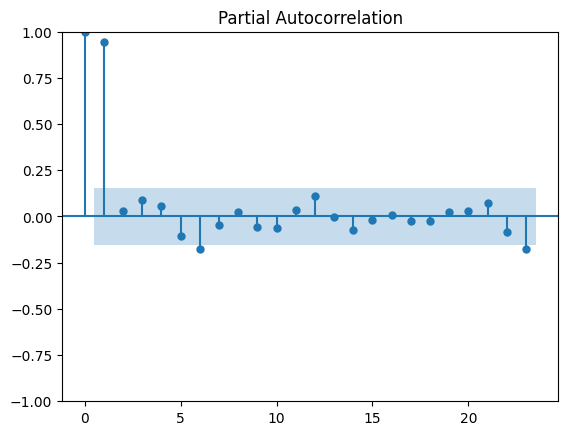

In [8]:
# Plot PACF
pacf = plot_pacf(df['Close'], method='ywm')
print(pacf)

Figure(640x480)


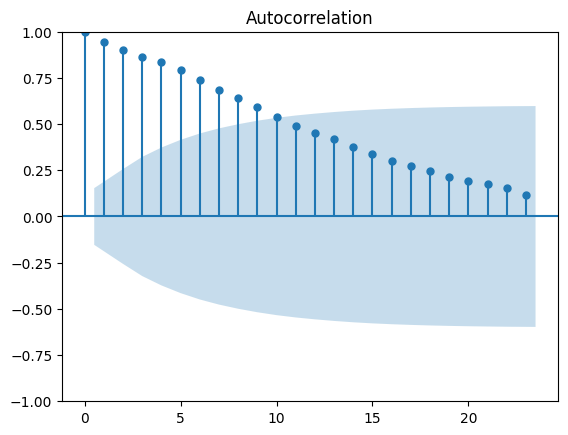

In [9]:
# Plot ACF
acf = plot_acf(df['Close'])
print(acf)

In [10]:
# Instantiation
model = ARIMA(train['Close'], order=(6,1,1)) # (1,1,1) is naive forecast

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [11]:
# Fit the model
result = model.fit()

In [12]:
# Calculate Train value prediction for ARIMA-train Column
df.loc[train_idx, 'ARIMA-Train'] = result.fittedvalues

In [13]:
# Plot
px.line(df.iloc[1:, :], x=df.index[1:], y=['Close', 'ARIMA-Train'])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 163 entries, 2023-01-03 to 2023-08-25
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         163 non-null    float64
 1   High         163 non-null    float64
 2   Low          163 non-null    float64
 3   Close        163 non-null    float64
 4   Adj Close    163 non-null    float64
 5   Volume       163 non-null    int64  
 6   ARIMA-Train  153 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 10.2 KB


In [15]:
# Out of sample prediction
prediction_result = result.get_forecast(n_test)
forecast = prediction_result.predicted_mean
df.loc[test_idx, 'ARIMA-Test'] = forecast.to_numpy()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 163 entries, 2023-01-03 to 2023-08-25
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         163 non-null    float64
 1   High         163 non-null    float64
 2   Low          163 non-null    float64
 3   Close        163 non-null    float64
 4   Adj Close    163 non-null    float64
 5   Volume       163 non-null    int64  
 6   ARIMA-Train  153 non-null    float64
 7   ARIMA-Test   10 non-null     float64
dtypes: float64(7), int64(1)
memory usage: 11.5 KB


In [17]:
# Plot
px.line(df.iloc[1:, :], x=df.index[1:], y=['Close', 'ARIMA-Train', 'ARIMA-Test'])

In [18]:
# Confidence interval
conf_int = prediction_result.conf_int()
conf_int

,lower Close,upper Close
153,174.476299,180.337173
154,173.059437,181.050693
155,172.275335,181.421522
156,171.672150,181.957553
157,170.947722,182.623805
158,169.970997,183.406200
159,169.123872,184.039550
160,168.451054,184.614625
161,167.820347,185.224000
162,167.158413,185.843279


In [19]:
df.loc[test_idx, 'lower Close'], df.loc[test_idx, 'upper Close'] = conf_int['lower Close'].to_numpy(), conf_int['upper Close'].to_numpy()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 163 entries, 2023-01-03 to 2023-08-25
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         163 non-null    float64
 1   High         163 non-null    float64
 2   Low          163 non-null    float64
 3   Close        163 non-null    float64
 4   Adj Close    163 non-null    float64
 5   Volume       163 non-null    int64  
 6   ARIMA-Train  153 non-null    float64
 7   ARIMA-Test   10 non-null     float64
 8   lower Close  10 non-null     float64
 9   upper Close  10 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 14.0 KB


In [20]:
# Drop first rows that ARIMA-Train are zero
df = df.drop(df[df['ARIMA-Train'] == 0].index)

In [21]:
# Plot
# The fill property is an enumeration that may be specified as one of the following enumeration values:
# ['none', 'tozeroy', 'tozerox', 'tonexty', 'tonextx', 'toself', 'tonext'].
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['lower Close'], name='Lower Close'))
fig.add_trace(go.Scatter(x=df.index, y=df['upper Close'], fill='tonexty', name='Upper Close'))
fig.add_trace(go.Scatter(x=df.index, y=df['Close'], name='Close'))
fig.add_trace(go.Scatter(x=df.index, y=df['ARIMA-Train'], name='ARIMA-Train'))
fig.add_trace(go.Scatter(x=df.index, y=df['ARIMA-Test'], name='ARIMA-Test', line=dict(color='firebrick', width=2)))
fig.show()